In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from abc import ABC, abstractmethod
from typing import Optional, List, Tuple
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FASHION_MNIST_LABELS = {
    0 :"T-shirt/top",
    1	:"Trouser",
    2	:"Pullover",
    3	:"Dress",
    4	:"Coat",
    5	:"Sandal",
    6	:"Shirt",
    7	:"Sneaker",
    8	:"Bag",
    9	:"Ankle boot",
}
print(device)

cuda


## Properties:
1. Conditional(Guided) Generation of Fashion MNIST given a embedding of labels using flow

## Procedures:
#### Training :
1. We sample from a joint distribution over conditioning variable z and guidance variable y (example z with label y). $y \in \mathcal{Y} : \mathbb{R}^{11} $ is the embedding of the digits and $\varnothing$
2. The __Guided Conditional Flow Matching Objective__ :
$$ \mathcal{L}_{CFM}^{Guided}(\theta) = \mathbb{E}_{(z,y) \sim p_{data(z, y)}, t \sim \mathcal{U}[0,1), x \sim p_t(\cdot | z)}[||u^{\theta}_t(x | y) - u^{target}_t(x | z)||^2] $$
3. The __Classifier Free Guided Conditional Flow Matching Objective__ :
$$ \mathcal{L}_{CFM}^{CFG}(\theta) = \mathbb{E}_{(z, y) \sim p_{data(z,y)}, t \sim \mathcal{U}[0,1), x \sim p_t(\cdot | z), \text{replace }y = \varnothing\text{ with prob. }\eta} [||u^{\theta}_t(x|y) - u^{target}_t(x|z)||^2] $$

#### Sampling:
1. The Same Euler sim is used for Flow Models $X_{t+h} = X_t + hu_t(X_t), X_0 \sim p_{init}$
2. But this time the drift coefficient changes under Classifier Free Guidance
$$ \tilde{u}_t^{\theta}(x | y) =  (1 - w) u_t^{\theta}(x | \varnothing) + w u_t^{\theta}(x | y) \text{, where } w \text{ is the guidance scale}$$

In [2]:
class Sampleable(ABC):
    '''
    Sampleable distributions
    '''
    @property
    @abstractmethod
    def dim(self) -> torch.Size:
        pass

    @abstractmethod
    def sample(self, batch_size : int) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        pass

class ConditionalProbabilityPath(nn.Module, ABC):
    def __init__(self, p_init : Sampleable, p_data : Sampleable):
        super().__init__()
        self.p_init = p_init
        self.p_data = p_data

    @abstractmethod
    def sample_conditioning_variable(self, batch_size : int) -> torch.Tensor:
        pass

    @abstractmethod
    def sample_conditional_path(self, z : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        pass

    @abstractmethod
    def conditional_vector_field(self, x : torch.Tensor, z : torch.Tensor, t : torch.Tensor) -> torch.Tensor:
        pass

class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt:torch.Tensor, t : torch.Tensor, **kwargs) -> torch.Tensor:
        pass

class Alpha(ABC):
    def __init__(self):
        super().__init__()

        assert torch.allclose(self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1))
        assert torch.allclose(self(torch.zeros(1,1,1,1)), torch.zeros(1,1,1,1))

    @abstractmethod
    def __call__(self, t):
        pass

    def dt(self, t):
        dt = torch.vmap(torch.func.jacrev(self))(t)
        return dt

class Beta(ABC):
    def __init__(self):
        super().__init__()

        assert torch.allclose(self(torch.zeros(1,1,1,1)), torch.ones(1,1,1,1))
        assert torch.allclose(self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1))

    @abstractmethod
    def __call__(self, t):
        pass

    def dt(self, t):
        dt = torch.vmap(torch.func.jacrev(self))(t)
        return dt

class ConditionalVectorField(nn.Module, ABC):
    def __init__(self):
        super().__init__()

    @abstractmethod
    def forward(self, xt : torch.Tensor, t : torch.Tensor, y : torch.Tensor) -> torch.Tensor:
        pass

class Trainer(ABC):
    def __init__(self, model : nn.Module):
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr : float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs : int, device : torch.device, lr : float = 1e-3, **kwargs) -> torch.Tensor:
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        pbar = tqdm(enumerate(range(num_epochs)))
        losses = []
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            losses.append(loss.detach())
            pbar.set_description(f'Epoch {idx} : loss : {loss.item() : .3f}')

        self.model.eval()
        return losses

In [3]:
class EulerSimulator():
    def __init__(self, ode : ODE):
        self.ode = ode

    def step(self, xt : torch.Tensor, t : torch.Tensor, h : torch.Tensor, **kwargs) -> torch.Tensor:
        return xt + h * self.ode.drift_coefficient(xt, t, **kwargs)

    @torch.no_grad()
    def simulate(self, x0 : torch.Tensor, ts : torch.tensor, **kwargs) -> torch.Tensor:
        nts = ts.shape[1]
        x = x0
        for t_idx in tqdm(range(nts-1)):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)

        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x0 : torch.Tensor, ts : torch.Tensor, **kwargs) -> torch.Tensor:
        nts = ts.shape[1]
        trajectory = [x0.clone()]
        x = x0
        for t_idx in tqdm(range(nts-1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h, **kwargs)
            trajectory.append(x.clone())
        return trajectory


In [4]:
class IsotropicGaussian(nn.Module, Sampleable):
    '''
    Wrapper around torch.randn
    '''
    def __init__(self, shape : List[int], std = 1.0):
        '''
            shape : shape of sampled data (number of means)
            std : common standard deviation for all dimensions (isotropic)
        '''
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1)) # something so that this qualifies as nn module

    def dim(self) -> torch.Size:
        return torch.Size(self.shape)

    def sample(self, num_samples : int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device), None


In [5]:
class GaussianProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_init_shape : List[int], p_data : Sampleable, alpha : Alpha, beta : Beta):
        p_init = IsotropicGaussian(p_init_shape)
        super().__init__(p_init, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, batch_size):
        z = self.p_data.sample(batch_size)
        return z

    def sample_conditional_path(self, z, t):
        x = self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
        return x

    def conditional_vector_field(self, x, z, t):
        u = (self.alpha.dt(t) - self.beta.dt(t) / self.beta(t) * self.alpha(t)) * z + self.beta.dt(t) / self.beta(t) * x
        return u

In [6]:
class LinearAlpha(Alpha):
    def __call__(self, t : torch.Tensor) -> torch.Tensor:
        return t

class LinearBeta(Beta):
    def __call__(self, t : torch.Tensor) -> torch.Tensor:
        return (1 - t)

In [7]:
class FashionMNIST(nn.Module, Sampleable):
    def __init__(self, batch_size = 128):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = datasets.FashionMNIST(
            root = './data/',
            train = True,
            download = True,
            transform = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5))
            ])
        )
        self.dummy = nn.Buffer(torch.zeros(1))

    def dim(self) -> torch.Size:
        return torch.Size([1,32,32])

    def sample(self, batch_size : int) -> torch.Tensor:

        if batch_size != self.batch_size:
            self.batch_size = batch_size
            self.loader = DataLoader(
                self.dataset, self.batch_size,
                shuffle = True, num_workers=2, pin_memory=True,
                drop_last=True
            )
            self.iterator = iter(self.loader)

        try:
            samples, labels = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            samples, labels = next(self.iterator)

        samples = samples.to(self.dummy)
        labels = labels.to(self.dummy.device)
        return samples, labels

In [8]:
class TrueFlowODE(ODE):
    def __init__(self, path : ConditionalProbabilityPath, z : torch.Tensor):
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, xt, t, **kwargs) -> torch.Tensor:
        return self.path.conditional_vector_field(xt, self.z, t)

class ClassifierFreeGuidanceODE(ODE):
    def __init__(self, net : nn.Module, guidance_scale : float = 1.0):
        super().__init__()
        self.net = net
        self.guidance_scale = guidance_scale

    def drift_coefficient(self, xt : torch.Tensor, t : torch.Tensor, y : torch.Tensor) -> torch.Tensor:

        guided_VF = self.net(xt, t, y)
        unguided_y = torch.ones_like(y) * 10
        unguided_VF = self.net(xt, t, unguided_y)

        return (1 - self.guidance_scale) * unguided_VF + self.guidance_scale * guided_VF

In [9]:
class ClassifierFreeGuidanceTrainer(Trainer):
    def __init__(self, model : ConditionalVectorField, path : ConditionalProbabilityPath, eta : float):
        assert eta > 0 and eta < 1
        super().__init__(model)
        self.path = path
        self.eta = eta

    def get_train_loss(self, batch_size : int) -> torch.Tensor:
        # sample z, y from joint distribution
        z, y = self.path.p_data.sample(batch_size)

        z.to(device)
        y.to(device)

        # set y = null with probability eta
        mask = torch.rand_like(y.float()) < self.eta
        y[mask] = 10

        # sample a time t and sample x from the conditional probability path
        t = torch.rand(batch_size, 1, 1, 1).to(device)
        x = self.path.sample_conditional_path(z, t)

        loss = torch.mean(torch.norm_except_dim(self.model(x, t, y) - self.path.conditional_vector_field(x, z ,t))**2)

        return loss

## FASHION MNIST TRUE FLOW

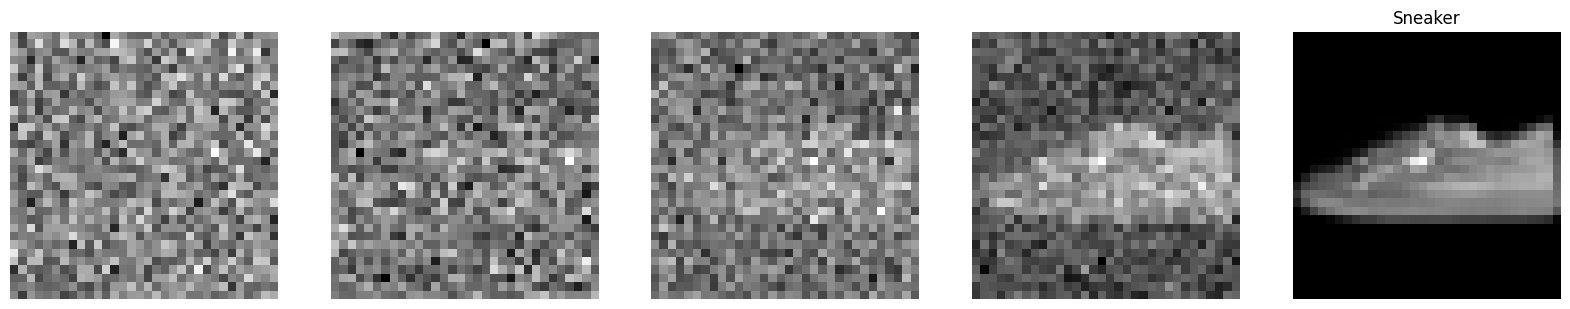

In [10]:
num_timesteps = 5

path = GaussianProbabilityPath(
    p_init_shape=[1, 32, 32], # c * h * w
    p_data=FashionMNIST(),
    alpha=LinearAlpha(),
    beta=LinearBeta()
).to(device)

z, y = path.p_data.sample(1)
z = z.to(device)

ts = torch.linspace(0,1,num_timesteps).to(device)

fig, axes = plt.subplots(1,num_timesteps,figsize=(num_timesteps * 4, 4))
for tidx, t in enumerate(ts):
    t = t.view(1,1,1,1)
    x = path.sample_conditional_path(z, t).squeeze(0)
    axes[tidx].imshow(x.permute(1, 2, 0).cpu(), cmap='gray')
    axes[tidx].axis('off')

plt.title(f'{FASHION_MNIST_LABELS[y.item()]}')
plt.show()

## THE U-NET

In [11]:
#TIME EMBEDDING
class TimeEmbedder(nn.Module):
    def __init__(self, dim : int):
        '''
        dim : size of time embedding vector
        '''
        super().__init__()
        assert dim % 2 == 0
        self.half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(1, self.half_dim))

    def forward(self, t : torch.Tensor) -> torch.Tensor:
        '''
        Args:
            t : Size(bs, 1, 1, 1)
        Returns:
            embedded_t : Size(bs, embedding_dim)
        '''
        t = t.view(-1,1)
        freqs = t * self.weights * 2 * torch.pi
        sin_embed = freqs.sin()
        cos_embed = freqs.cos()
        embedded_t = torch.cat([sin_embed, cos_embed], dim = -1) * math.sqrt(2)
        return embedded_t
#RESIDUAL BLOCK
class ResidualBlock(nn.Module):
    def __init__(self, channels : int, time_embed_dim : int, y_embed_dim : int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.SiLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.SiLU(),
        )
        self.time_adapter = nn.Sequential(
            nn.Linear(time_embed_dim,time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, channels)
        )
        self.y_adapter = nn.Sequential(
            nn.Linear(y_embed_dim, y_embed_dim),
            nn.SiLU(),
            nn.Linear(y_embed_dim, channels)
        )
    def forward(self, x : torch.Tensor, time_embed : torch.Tensor, y_embed : torch.Tensor) -> torch.Tensor:
        res = x.clone()

        x = self.layer1(x)

        time_embed = self.time_adapter(time_embed).unsqueeze(-1).unsqueeze(-1)
        y_embed = self.y_adapter(y_embed).unsqueeze(-1).unsqueeze(-1)

        x = x + time_embed + y_embed

        x = self.layer2(x)

        x = x + res

        return x
#SINGLE ENCODER BLOCK
class Encoder(nn.Module):
    def __init__(self, in_channels : int, out_channels : int, num_res_blocks : int, time_embed_dim : int, y_embed_dim : int):
        super().__init__()
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(in_channels, time_embed_dim, y_embed_dim) for _ in range(num_res_blocks)]
        )
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x : torch.Tensor, time_embed : torch.Tensor, y_embed : torch.Tensor) -> torch.Tensor:
        for res_block in self.res_blocks:
            x = res_block(x, time_embed, y_embed)
        x = self.downsample(x)
        return x
#SINGLE DECODER BLOCK
class Decoder(nn.Module):
    def __init__(self, in_channels : int, out_channels : int, num_res_blocks, time_embed_dim : int, y_embed_dim : int):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        )
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(out_channels, time_embed_dim, y_embed_dim) for _ in range(num_res_blocks)]
        )
    def forward(self, x : torch.Tensor, time_embed : torch.Tensor, y_embed : torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)
        for res_block in self.res_blocks:
            x = res_block(x, time_embed, y_embed)
        return x
#MID-SECTION ASSEMBLY
class BottleNeck(nn.Module):
    def __init__(self, channels : int, num_res_blocks, time_embed_dim : int, y_embed_dim : int):
        super().__init__()
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(channels, time_embed_dim, y_embed_dim) for _ in range(num_res_blocks)]
        )
    def forward(self, x : torch.Tensor, time_embed : torch.Tensor, y_embed : torch.Tensor) -> torch.Tensor:
        for res_block in self.res_blocks:
            x = res_block(x, time_embed, y_embed)
        return x
#ASSEMBLY - feed guidance and temporal embeddings to each and every layer, feed Residuals from Encoder to decoder
class MNISTUNet(ConditionalVectorField):
    def __init__(self, channels : List[int], num_res_blocks : int, time_embed_dim : int, y_embed_dim : int):
        super().__init__()
        # Embedders
        self.time_embedder = TimeEmbedder(time_embed_dim)
        self.y_embedder = nn.Embedding(num_embeddings=11, embedding_dim=y_embed_dim)
        # Init
        self.conv_init = nn.Sequential(
            nn.Conv2d(1, channels[0], kernel_size=3, padding=1),
            nn.SiLU()
        )
        # Downstream
        self.encoders = nn.ModuleList(
            [Encoder(channels[i-1],channels[i],num_res_blocks,time_embed_dim,y_embed_dim) for i in range(1,len(channels))]
        )
        # River
        self.bottleneck = BottleNeck(channels[-1], num_res_blocks, time_embed_dim, y_embed_dim)
        # Upstream
        self.decoders = nn.ModuleList(
            [Decoder(channels[i], channels[i-1], num_res_blocks, time_embed_dim, y_embed_dim) for i in range(len(channels)-1,0,-1)]
        )
        # Final
        self.conv_out = nn.Conv2d(channels[0], 1, kernel_size=3, padding=1)

    def forward(self, x : torch.Tensor, t : torch.Tensor, y : torch.Tensor) -> torch.Tensor:

        time_embed = self.time_embedder(t)
        y_embed = self.y_embedder(y)

        x = self.conv_init(x)

        residuals : list= []
        for encoder in self.encoders:
            x = encoder(x, time_embed, y_embed)
            residuals.append(x.clone())

        x = self.bottleneck(x, time_embed, y_embed)

        for decoder in self.decoders:
            x = x + residuals.pop()
            x = decoder(x, time_embed, y_embed)

        assert len(residuals) == 0

        x = self.conv_out(x)
        return x

In [12]:
unet = MNISTUNet(
    channels=[64,128,256, 512],
    num_res_blocks=6,
    time_embed_dim=48,
    y_embed_dim=48,
).to(device)

MiB = 1024 ** 2
size = 0
for param in unet.parameters():
    size += param.nelement() * param.element_size()
for buf in unet.buffers():
    size += buf.nelement() * buf.element_size()
print(f'training model of size : {size / MiB :.3f} MiB')

path = GaussianProbabilityPath(
    p_init_shape=[1,32,32],
    p_data=FashionMNIST(),
    alpha=LinearAlpha(),
    beta =LinearBeta()
).to(device)

trainer = ClassifierFreeGuidanceTrainer(
    model = unet,
    path = path,
    eta = 0.1,
)

training model of size : 194.934 MiB


Epoch 3999 : loss :  59323.992: : 4000it [1:19:01,  1.19s/it]


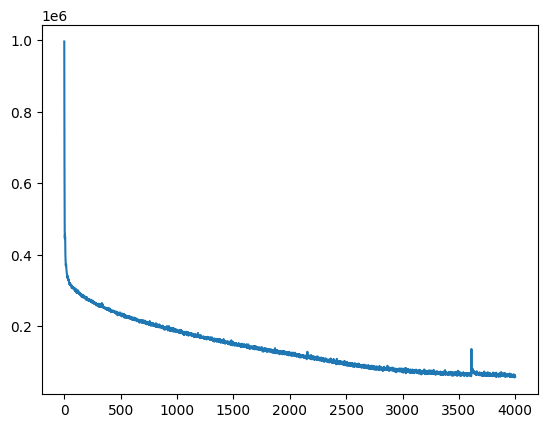

In [ ]:
try :
    losses = trainer.train(
        num_epochs=4000,
        device=device,
        lr = 1e-5,
        batch_size = 256
    )

except KeyboardInterrupt:
    print('Training Stopped by user')

torch.save(unet.state_dict(),'./models/net6789-6-48-48-0.1.pth')
plt.plot(torch.stack(losses).cpu())

In [ ]:
# unet.load_state_dict(torch.load('./models/net6789-6-48-48-0.1.pth'))

100%|██████████| 99/99 [00:07<00:00, 14.01it/s]


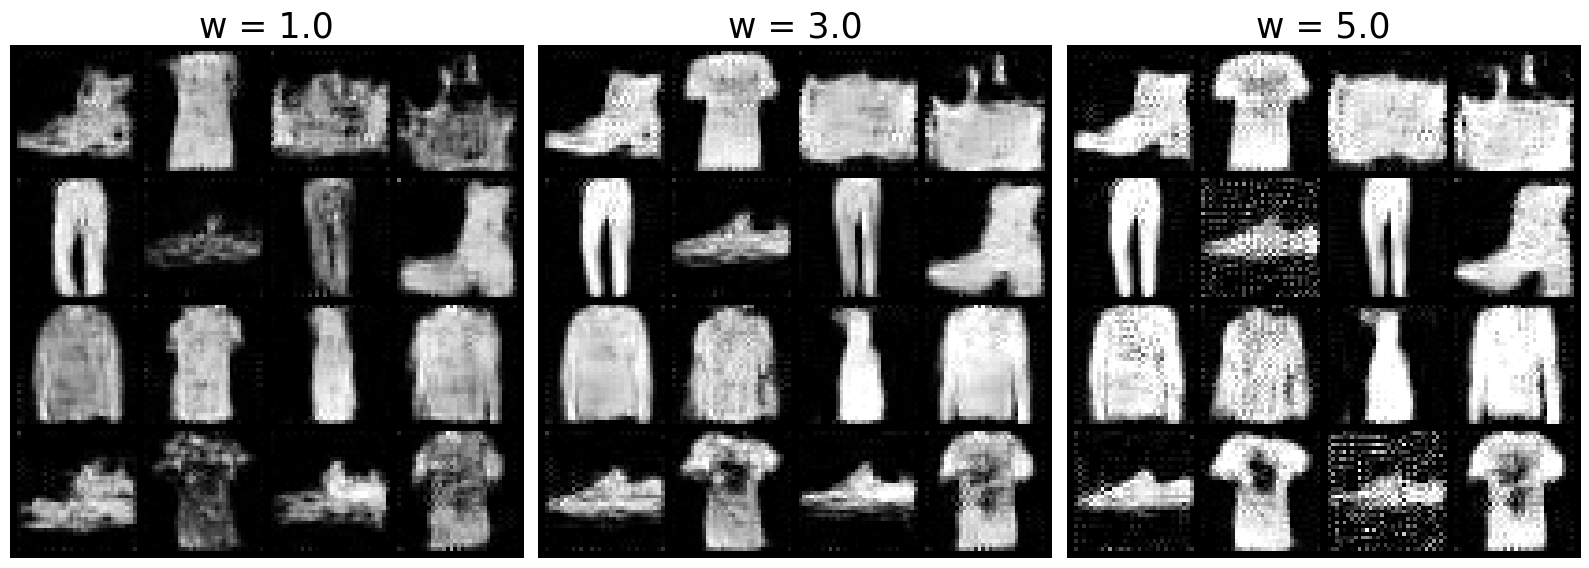

In [25]:
guidance_scales = [1.0, 3.0, 5.0]
samples = 16
y=torch.randint(0,10,(samples,)).to(device)
ts = torch.linspace(0, 1, 100).unsqueeze(0).to(device)
x0, _ = path.p_init.sample(samples)
fig, axes = plt.subplots(1, 3,figsize=(16,48))

for idx, w in enumerate(guidance_scales):
    ode = ClassifierFreeGuidanceODE(net=unet, guidance_scale=w)
    sim = EulerSimulator(ode)
    x1 = sim.simulate(x0, ts, y=y)
    grid = make_grid(x1,nrow=4,normalize=True, value_range=(-1,1))
    axes[idx].set_title(f'w = {w}', fontsize=25)
    axes[idx].imshow(grid.permute(1,2,0).cpu(), cmap='gray')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()


In [23]:
# torch.cuda.empty_cache()

In [ ]:
# from google.colab import files

# files.download("./models/net6789-6-48-48-0.1.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>